In [1]:
%matplotlib inline
import os
import glob
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
object_observed = "GOES 18 [51850, 2022-021A]"
frequency = "2211.054"

# EUTE 7A is LHCP
#object_observed = "EUTE 7A [28187, 2004-008A]"
#frequency = "2265.384"

In [3]:
calibrate = True
nfft = 4096
samp_rate = 4e6
decim1 = 1
integrate = int(samp_rate/decim1/nfft*100)

directory_path = '/home/scott/blade_test/data/GOES18_51850_2023-10-08/'

filename_pattern = '*.xx.f32'

latest_file = max(glob.glob(os.path.join(directory_path, filename_pattern)), key=os.path.getctime)

filename_parts = os.path.basename(latest_file).split('.')[0].split('_')
date_str = filename_parts[0]  # Format: yyyy-mm-ddThh:mm:ss

date_format = "%Y-%m-%dT%H:%M:%S"
datetime_obj = datetime.strptime(date_str, date_format)
formatted_datetime = datetime_obj.strftime("%Y-%m-%dT%H:%M:%S")

xx = np.fromfile(os.path.join(directory_path, f'{formatted_datetime}.xx.f32'), dtype='float32').reshape((-1, nfft))
yy = np.fromfile(os.path.join(directory_path, f'{formatted_datetime}.yy.f32'), dtype='float32').reshape((-1, nfft))
xy = np.fromfile(os.path.join(directory_path, f'{formatted_datetime}.xy.c64'), dtype='complex64').reshape((-1, nfft))

t = np.arange(xx.shape[0]) * 610 * nfft * 8 / 2e6 * 1e3 * np.timedelta64(1, 'ms') + np.datetime64(datetime_obj)
print("Latest Filename:", latest_file)
print("Datetime:", datetime_obj)


Latest Filename: /home/scott/blade_test/data/GOES18_51850_2023-10-08/2023-10-08T08:18:09.xx.f32
Datetime: 2023-10-08 08:18:09


Column Index for Peak Value: 2053
Gain Offset: 1.2659141
shape of XY:  (4040, 4096)
Column Index for Peak Value: 2053
Complex Phase Angle (Degrees) of Peak Value: 136.3296879088624


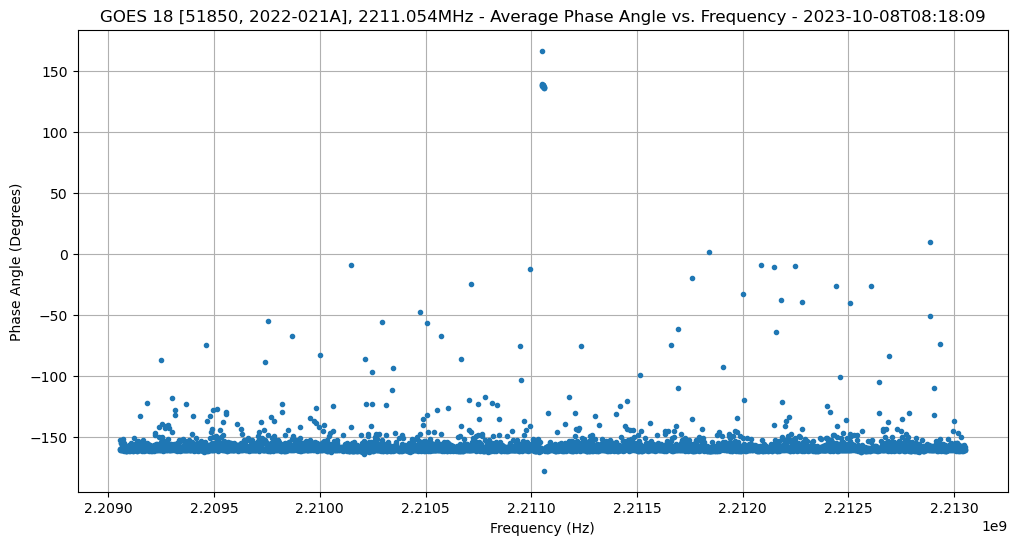

In [4]:
peak_column_index = np.argmax(np.max(np.abs(xx), axis=0))
xx_peak = xx[:, peak_column_index]
yy_peak = yy[:, peak_column_index]
gain_offset = np.average(xx_peak / yy_peak)
print("Column Index for Peak Value:", peak_column_index)
print("Gain Offset:", gain_offset)
print("shape of XY: ", np.shape(xy))
#gain_offset = np.average((np.max(xx[peak_value])/np.max(yy[peak_value])))# Assumes when purely RHCP or LHCP that the peaks should be the same.

#gain_offset = np.average((np.median(xx, axis = 1)/np.median(yy, axis = 1))) # referenced to the noise floor...

yy *= gain_offset
xy *= np.sqrt(gain_offset)

n_rows,n_col = xy.shape
avg_complex_value = 0
for _ in range(n_rows):
    avg_complex_value += np.mean(xy, axis=0)
avg_complex_value /= n_rows
peak_value = np.max(np.abs(avg_complex_value))
peak_column_index = np.argmax(np.abs(avg_complex_value)) 
phase_angle_degrees = np.angle(avg_complex_value[peak_column_index], deg=True)
print("Column Index for Peak Value:", peak_column_index)
print("Complex Phase Angle (Degrees) of Peak Value:", phase_angle_degrees)

# NOTE: DSCOVR is LHCP, so using its phase to calibrate while keeping circular polarization convention.
#xy *= np.exp(-1j*np.deg2rad(phase_angle_degrees+180))*(-1j) # correct for X-Y phase offset

frequency_values = np.arange((samp_rate/decim1)/-2.0, (samp_rate/decim1)/2.0, (samp_rate/decim1)/nfft)
frequency_values += float(frequency) *1e6

plt.figure(figsize=(12, 6))
plt.plot(frequency_values, np.angle(avg_complex_value, deg=True),'.')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase Angle (Degrees)')
plt.title(f'{object_observed}, {frequency}MHz - Average Phase Angle vs. Frequency - {formatted_datetime}')
plt.grid(True)

filename = f'{object_observed}_{formatted_datetime}_avg_phase_freq.png'
plt.savefig(filename)

xy *= np.exp(-1j*np.deg2rad(phase_angle_degrees))*(-1j) # correct for X-Y phase offset

Minimum Value: -85.04094123840332
Maximum Value: -5.088292360305786


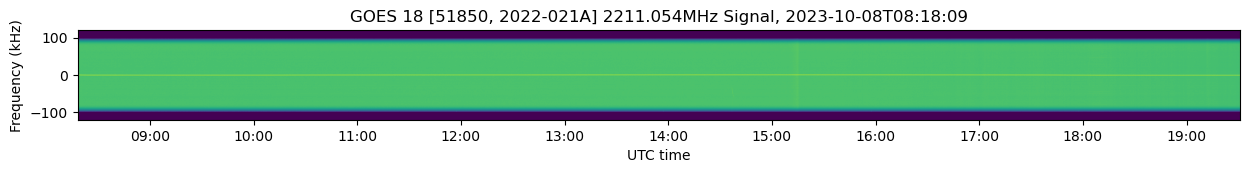

In [5]:
result = xx + yy
min_value = 10*np.log10(np.min(result))
max_value = 10*np.log10(np.max(result))
print("Minimum Value:", min_value)
print("Maximum Value:", max_value)

plt.figure(figsize = (15,15), facecolor = 'w')
plt.imshow(10*np.log10(xx+yy)[:,::-1].T, extent = (mdates.date2num(t[0]),mdates.date2num(t[-1]), -120, 120),
          aspect = 1.5e-4,  vmin = -35, vmax = -23)
plt.gca().set_xlim((t[0], t[-1]))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.ylabel('Frequency (kHz)')
plt.xlabel('UTC time')

title_text = f'{object_observed} {frequency}MHz Signal, {formatted_datetime}'
plt.title(title_text)

filename = f'{object_observed}_{formatted_datetime}_sig_plot.png'
plt.savefig(filename)

In [6]:
signal_peak = np.argmax(xx + yy, axis = 1)
offsets = np.arange(-2,3)
signal_xx = np.zeros(xx.shape[0])
signal_yy = np.zeros(yy.shape[0])
signal_xy = np.zeros(xy.shape[0], dtype = 'complex')
for offset in np.arange(-2,3):
    signal_xx += xx[np.arange(signal_peak.shape[0]), signal_peak + offset]
    signal_yy += yy[np.arange(signal_peak.shape[0]), signal_peak + offset]
    signal_xy += xy[np.arange(signal_peak.shape[0]), signal_peak + offset]
signal_xx /= offsets.size
signal_yy /= offsets.size
signal_xy /= offsets.size
gain_xx_yy = np.median(signal_xx + signal_yy)
signal_xx /= gain_xx_yy
signal_yy /= gain_xx_yy
signal_xy /= gain_xx_yy

In [7]:
I = signal_xx + signal_yy
Q = signal_xx - signal_yy
U = 2*signal_xy.real
V = -2*signal_xy.imag
L = Q + 1j*U
P = np.sqrt(Q**2 + U**2 + V**2)

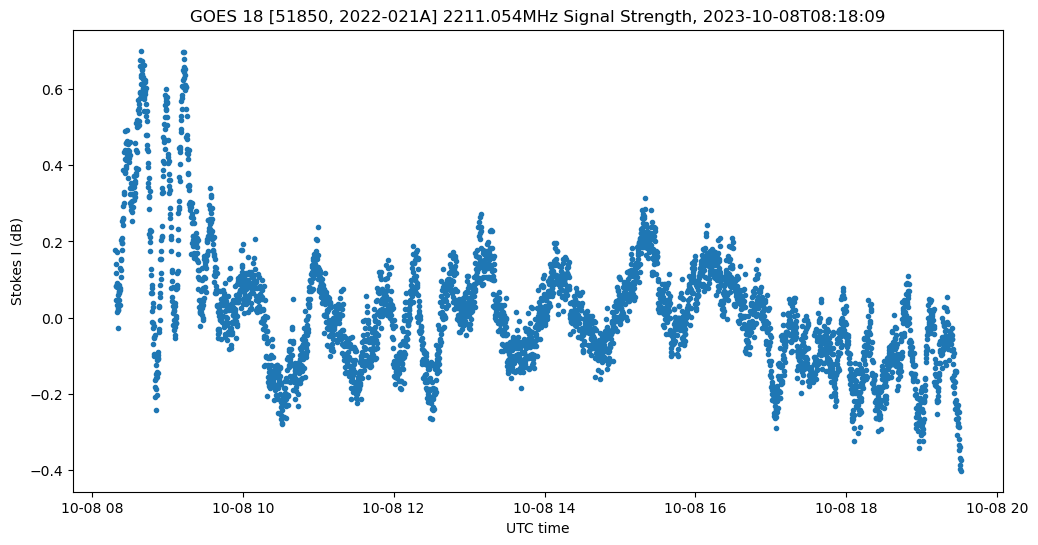

In [8]:
sel = slice(3,None)
plt.figure(figsize = (12, 6))
plt.plot(t[sel], 10*np.log10(I[sel]), '.')
plt.ylabel('Stokes I (dB)')
plt.xlabel('UTC time')

title_text = f'{object_observed} {frequency}MHz Signal Strength, {formatted_datetime}'
plt.title(title_text)

filename = f'{object_observed}_{formatted_datetime}_sig_strength.png'
plt.savefig(filename)

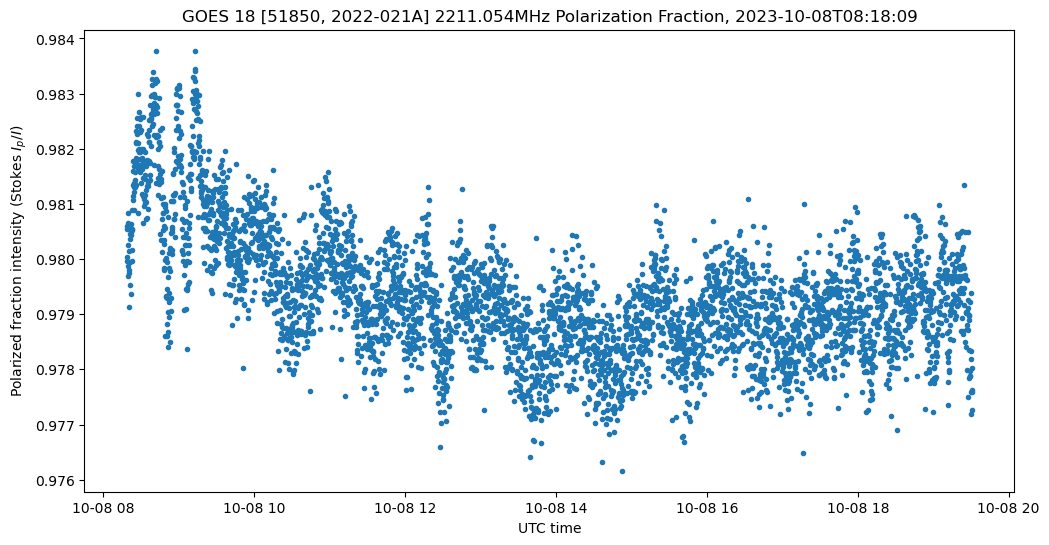

In [9]:
plt.figure(figsize = (12, 6))
plt.plot(t[sel], (P/I)[sel], '.')
plt.xlabel('UTC time')
plt.ylabel('Polarized fraction intensity (Stokes $I_p/I$)')
title_text = f'{object_observed} {frequency}MHz Polarization Fraction, {formatted_datetime}'
plt.title(title_text)
filename = f'{object_observed}_{formatted_datetime}_pol_frac.png'
plt.savefig(filename)

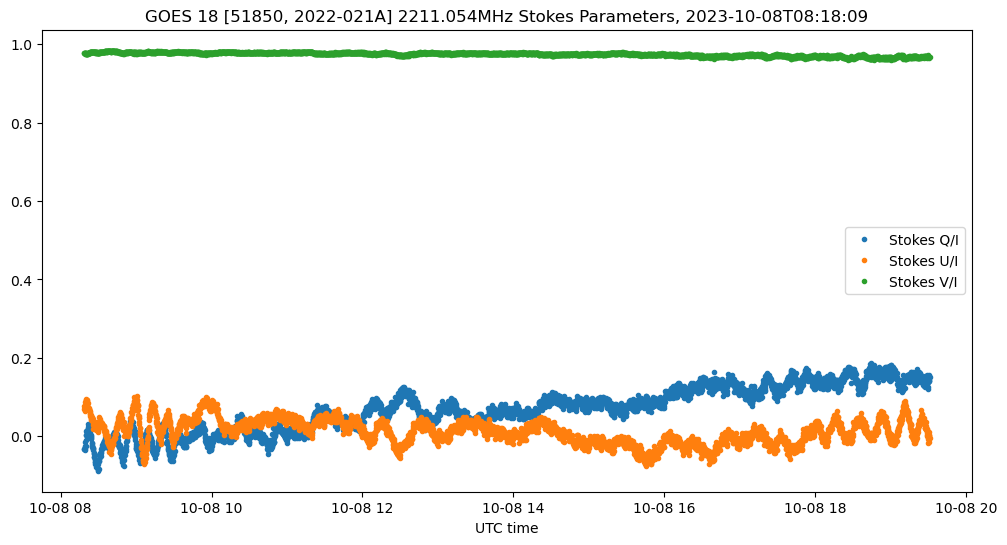

In [10]:
plt.figure(figsize = (12, 6))
plt.plot(t[sel], (Q/I)[sel], '.')
plt.plot(t[sel], (U/I)[sel], '.')
plt.plot(t[sel], (V/I)[sel], '.')
plt.legend(['Stokes Q/I', 'Stokes U/I', 'Stokes V/I'])
plt.xlabel('UTC time')
title_text = f'{object_observed} {frequency}MHz Stokes Parameters, {formatted_datetime}'
plt.title(title_text)
filename = f'{object_observed}_{formatted_datetime}_stokes_par.png'
plt.savefig(filename)

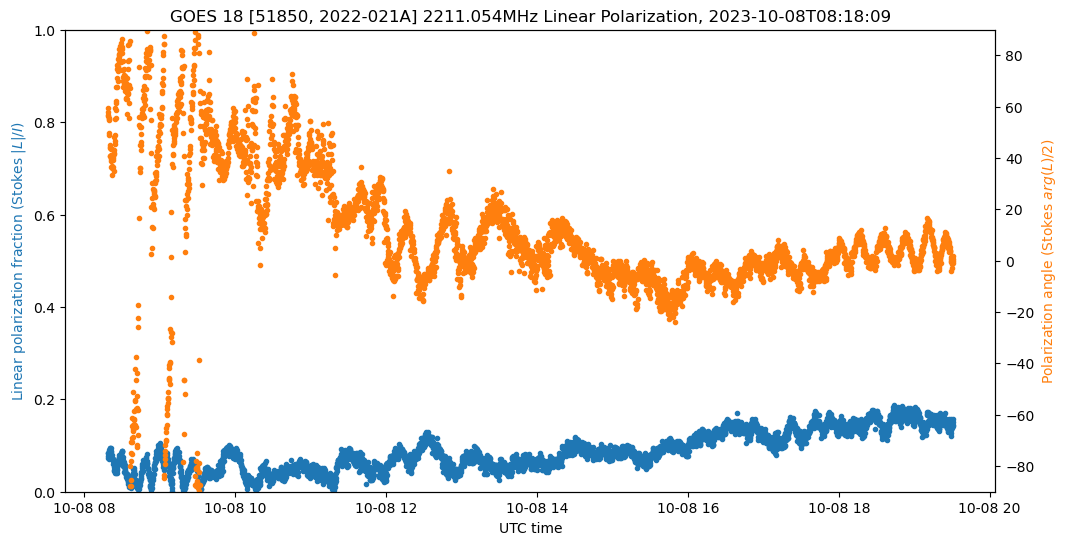

In [11]:
plt.figure(figsize = (12, 6))
plt.plot(t[sel], (np.abs(L)/I)[sel], '.')
plt.ylim((0,1))
plt.xlabel('UTC time')
plt.ylabel('Linear polarization fraction (Stokes $|L|/I$)', color = 'C0')
ax2 = plt.gca().twinx()
plt.plot(t[sel], np.rad2deg(np.angle(L[sel])/2), '.', color = 'C1')
ax2.set_ylabel('Polarization angle (Stokes $arg(L)/2$)', color = 'C1')
ax2.set_ylim((-90,90))
title_text = f'{object_observed} {frequency}MHz Linear Polarization, {formatted_datetime}'
plt.title(title_text)
filename = f'{object_observed}_{formatted_datetime}_lin_pol.png'
plt.savefig(filename)

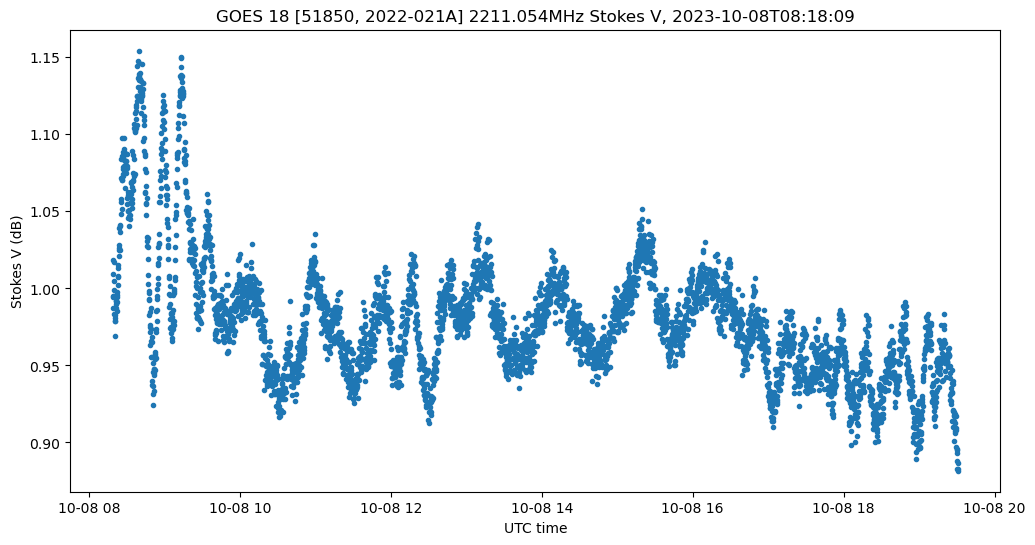

In [12]:
plt.figure(figsize = (12, 6))
plt.plot(t[sel], (V)[sel], '.')
plt.xlabel('UTC time')
plt.ylabel('Stokes V (dB)')
title_text = f'{object_observed} {frequency}MHz Stokes V, {formatted_datetime}'
plt.title(title_text)
filename = f'{object_observed}_{formatted_datetime}_stokes_V.png'
plt.savefig(filename)